In [77]:
from qiskit import *
from math import log2, ceil
from qiskit.circuit.library import XGate, UnitaryGate
from qiskit.circuit import Gate

In [7]:
def encode_table(l: list[int], size: int) -> list[str]:
    """
    l: list to be encoded
    size: how many bits elements should have in it's encoding
    """
    encoded_l = []
    for num in l:
        encoded_l.append((bin(num)[2:]).rjust(size,"0"))
    return encoded_l

l = [4,2,3,1,6,5,8,7]
print(encode_table(l, 4))

['0100', '0010', '0011', '0001', '0110', '0101', '1000', '0111']


In [111]:
def generate_control_strings(size: int) -> list[str]:
    """
    size: number of bits to encode list size
    """
    c_strings = []
    string_size = ceil(log2(size))
    for i in range(size):
        c_strings.append((bin(i)[2:]).rjust(string_size,"0"))
    return c_strings

print(generate_control_strings(6))

['000', '001', '010', '011', '100', '101']


In [178]:
def xor_data_gates(l: list[str], size: int) -> list[Gate]:
    """
    create a list of gates wich cnots the data in list to qubits
    """
    circuits = []
    for bit_string in l:
        qc = QuantumCircuit(size)
        for bit in range(len(bit_string)):
            if bit_string[bit] == "1":
                qc.x(abs(bit-size)-1)
        circuits.append(qc.to_gate())

    for i in range(len(circuits)):
        circuits[i].name = f"L{i}"
    return circuits

circs = xor_data_gates(['0100', '0010', '0011', '0001', '0110', '0101', '1000', '0111'], 4)

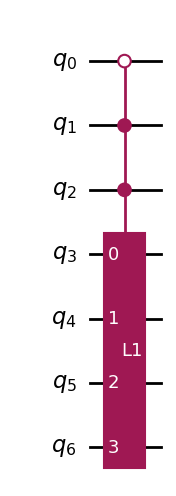

In [179]:
qc = QuantumCircuit(7)
qc.append(circs[1].control(3, ctrl_state="110"), [0,1,2,3,4,5,6])
qc.draw("mpl")

In [94]:
c_strings = generate_control_strings(6)
print("1" + c_strings[5])

1101


In [132]:
num = 9
print(ceil(log2(num)))

4


In [10]:
def calculate_exp_table(W: int, a: int, N: int) -> list[int]:
    exp_table = [0]*((2**W))
    for d in range(1,(2**W),2):
        exp_table[d] = ((a**d) % N)
    return exp_table

print(calculate_exp_table(2,3,31))

[0, 3, 0, 27]


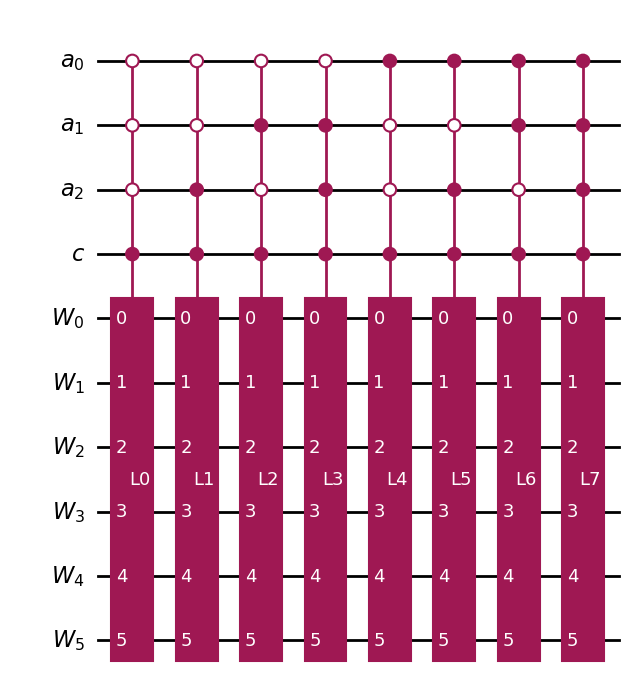

In [184]:
def compute_lookup_table(W: int, l: list[int], optimization: int = 0) -> QuantumCircuit:
    """
    a = input; input size in bits is log2(len(l)), ex: if len(l) = 8, then input size is 3, log2(8)=3, 2^3 = 8
    w = output size in bits
    l = table to be computed
    c = controll qubit
    """
    index_size = ceil(log2(len(l)))
    a = QuantumRegister(index_size, name="a")
    w = QuantumRegister(W, name="W")
    c = QuantumRegister(1, name="c")
    quantum_circuit = QuantumCircuit(a, c, w)

    c_strings = generate_control_strings(len(l))
    e_table = encode_table(l, W)
    xor_circs = xor_data_gates(e_table, W)
    
    match optimization:
        case 0:
            for i in range(len(l)):
                get_data_circ = xor_circs[i].control(index_size + 1, ctrl_state="1" + c_strings[i][::-1])
                quantum_circuit.append(get_data_circ, a[:] + c[:] + w[:])

    
    return quantum_circuit

compute_lookup_table(6, [0,0,0,0,0,0,0,0]).draw("mpl")